In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import load
from joblib import dump
import myfunctions as mf

In [2]:
data_bs1 = pd.read_csv('../data/preprocessed_data_BS1.csv')
data_bs1.head()

,hg38_ASF1A,hg38_CCT7,hg38_EPOR,hg38_NECAP2,hg38_LRRC8A,hg38_NDUFS8,hg38_MRPL22,hg38_HIST1H2BC,hg38_LY96,hg38_UBE2E2-AS1,...,hg38_TMEM128,hg38_ASPSCR1,hg38_CDC20,hg38_DNAJB9,hg38_OSTM1,hg38_LCNL1,hg38_PHB,hg38_LRRC29,hg38_ZFP36,Group
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
1,0,0,0,3,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,2,0,3,B
3,0,0,0,0,0,3,0,0,0,0,...,0,0,0,3,0,0,3,0,0,B
4,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B


In [3]:
X = data_bs1.drop(['Group'], axis=1)
y = data_bs1['Group']

In [4]:
y.unique()

array(['B', 'D', 'M', 'NK', 'T'], dtype=object)

In [5]:
encoded_y = mf.replace_values(y)
encoded_y[:5], y[:5]

(0    0
 1    0
 2    0
 3    0
 4    0
 Name: Group, dtype: int64,
 0    B
 1    B
 2    B
 3    B
 4    B
 Name: Group, dtype: object)

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=0.3)

In [3]:
from xgboost import XGBClassifier

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

model = XGBClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='accuracy', cv=3, verbose=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [14]:
best_params, best_score

({'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300},
 0.9604464672735155)

In [8]:
best_params = {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

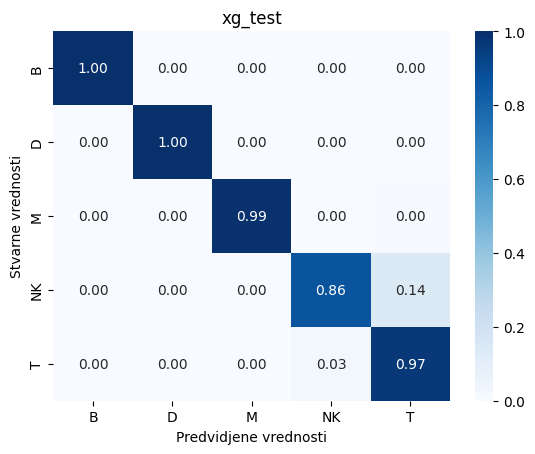

Matrica konfuzije:
 [[ 516    0    1    0    1]
 [   0   41    0    0    0]
 [   0    1  493    0    2]
 [   1    0    0  338   53]
 [   1    0    1   78 2428]]
Accuracy score:  0.9648546144121365
Precision score:  0.9658606084242318
Recall score:  0.9648546144121365
F1 score:  0.9652685143754052


In [10]:
mf.model_info(y_test, best_model.predict(X_test), 'xg_test')

In [9]:
dump(best_model, 'trained_models/xg.joblib')

['xg.joblib']

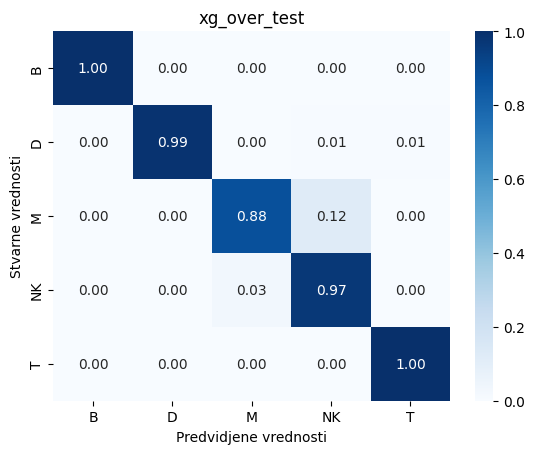

Matrica konfuzije:
 [[ 517    1    0    0    0]
 [   0  490    0    3    3]
 [   1    0  343   48    0]
 [   1    1   79 2427    0]
 [   0    0    0    0   41]]
Accuracy score:  0.9653603034134007
Precision score:  0.9666727734984888
Recall score:  0.9653603034134007
F1 score:  0.9658659427990096


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [4]:
train_data = pd.read_csv('../data/oversampled_train_BS1.csv')
X_train = train_data.drop(['Group'], axis=1)
y_train = train_data['Group']
y_train = mf.replace_values(y_train)
test_data = pd.read_csv('../data/oversampled_test_BS1.csv')
X_test = test_data.drop(['Group'], axis=1)
y_test = test_data['Group']
y_test = mf.replace_values(y_test)
best_params = {
    'learning_rate': 0.2,
    'max_depth': 4,
    'n_estimators': 300
}
model_over = XGBClassifier(**best_params)
mf.build_model(model_over, X_train, X_test, y_train, y_test, 'xg_over_test')

In [5]:
dump(model_over, 'trained_models/xg_over.joblib')

['xg_over.joblib']